In [73]:
### Si données locales
library(Matrix)
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)

m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA

# Cosinus normal des lignes d'une matrice
matrix.cos <- function(m) {
     (m %*% t(m)) / ( t(matrix(sqrt(rowSums(m^2)),nrow(m),nrow(m)))
                    * (sqrt(rowSums(m^2))) )
}
# on normalise les ages
u.user.norm <- u.user
u.user.norm$age = (u.user.norm$age - min(u.user.norm$age)) / (max(u.user.norm$age) - min(u.user.norm$age))

# on normalise les votes
u.data.norm <- u.data
u.data.norm$rating = (u.data.norm$rating - min(u.data.norm$rating)) / (max(u.data.norm$rating) - min(u.data.norm$rating))

m.na.norm <- m.na/5
m.norm <- m/5



In [32]:
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

In [33]:
head(m)

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
u1,5,3,4,3,3,5,4,1,5,3,...,0,0,0,0,0,0,0,0,0,0
u2,4,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
u3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u6,4,0,0,0,0,0,2,4,4,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# merge users and ratings
names(u.user)<- c('user.id','age','gender','job')
u.user <- u.user[,c(-5)]
head(u.user)

names(u.data)<- c('user.id','movie.id','rating')
u.data <- u.data[,c(-4)]
head(u.data)

u.item <- u.item[,c(-2,-3,-4,-5)]
head(u.item)

u.r <- merge(u.user, u.data, by = "user.id")
head(u.r)
# merge userRating with movie to have actual movie titles instead of ids
u.r.v <- merge(u.r, u.item, by = "movie.id")
head(u.r.v)


user.id,age,gender,job
1,24,M,technician
2,53,F,other
3,23,M,writer
4,24,M,technician
5,33,F,other
6,42,M,executive


user.id,movie.id,rating
196,242,3
186,302,3
22,377,1
244,51,2
166,346,1
298,474,4


movie.id,unknown,Action,Adventure,Animation,Children.s,Comedy,Crime,Documentary,Drama,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


user.id,age,gender,job,movie.id,rating
1,24,M,technician,259,1
1,24,M,technician,264,2
1,24,M,technician,194,4
1,24,M,technician,183,5
1,24,M,technician,40,3
1,24,M,technician,226,3


movie.id,user.id,age,gender,job,rating,unknown,Action,Adventure,Animation,...,Fantasy,Film.Noir,Horror,Musical,Mystery,Romance,Sci.Fi,Thriller,War,Western
1,918,40,M,scientist,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,684,28,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,660,26,M,student,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,339,35,M,lawyer,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,699,44,M,other,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,94,26,M,student,4,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [87]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.c], m.na[i.test.c])
    }


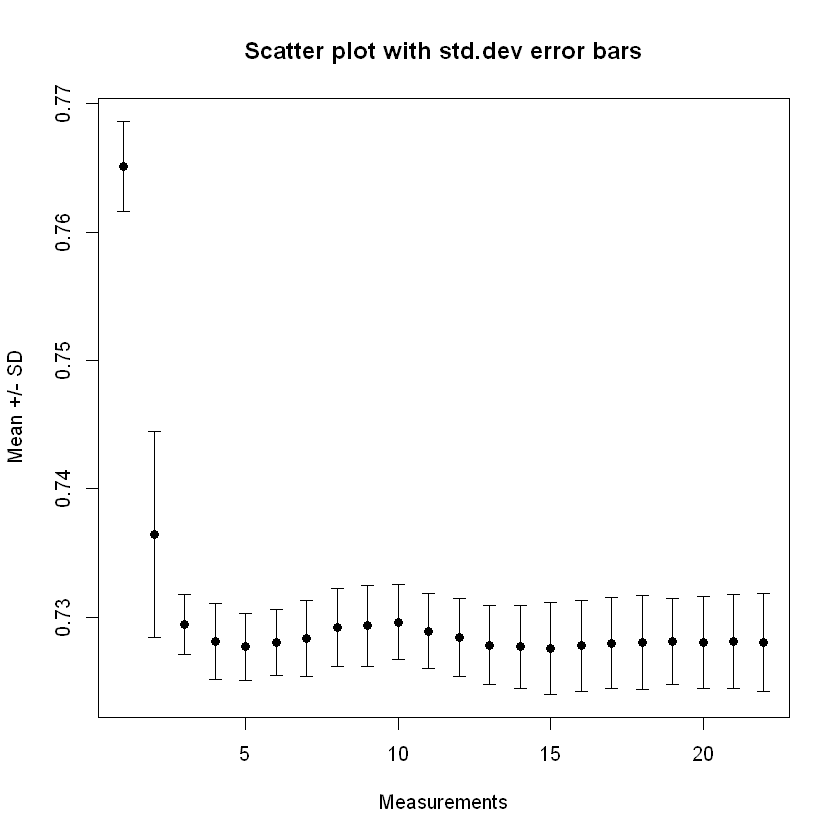

In [320]:
to.plot <- c()
cv.c <- c()
for (i in seq_len(5)){
m1 <- read.csv(file=paste("out/embed/m",toString(i),".csv", sep = ""), sep = ",",header = F) # drops the rownames

test1 <- read.csv(file=paste("out/embed/test",toString(i),".csv", sep = ""), sep = ",",header = F) # drops the rownames
test1 <- unlist(test1)
i.test.c <- rep(FALSE,943*1682)
for (j in seq_len(length(test1))){
    i.test.c[943*(u.data[test1[j]+1,2]-1)+u.data[test1[j]+1,1]]<-TRUE
}
    m1[m1==0]<-NA
    m1[is.na(m1)]<-rep(rowMeans(m1,na.rm=T),1682)[is.na(m1)]
    m1[is.na(m1)]<-rep(colMeans(m1,na.rm=T),943)[is.na(m1)]
m.train <- m1
cv.c <- c(cv.c ,mae(as.matrix(m1)[i.test.c],m.na[i.test.c]))
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))

}
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Embedding"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

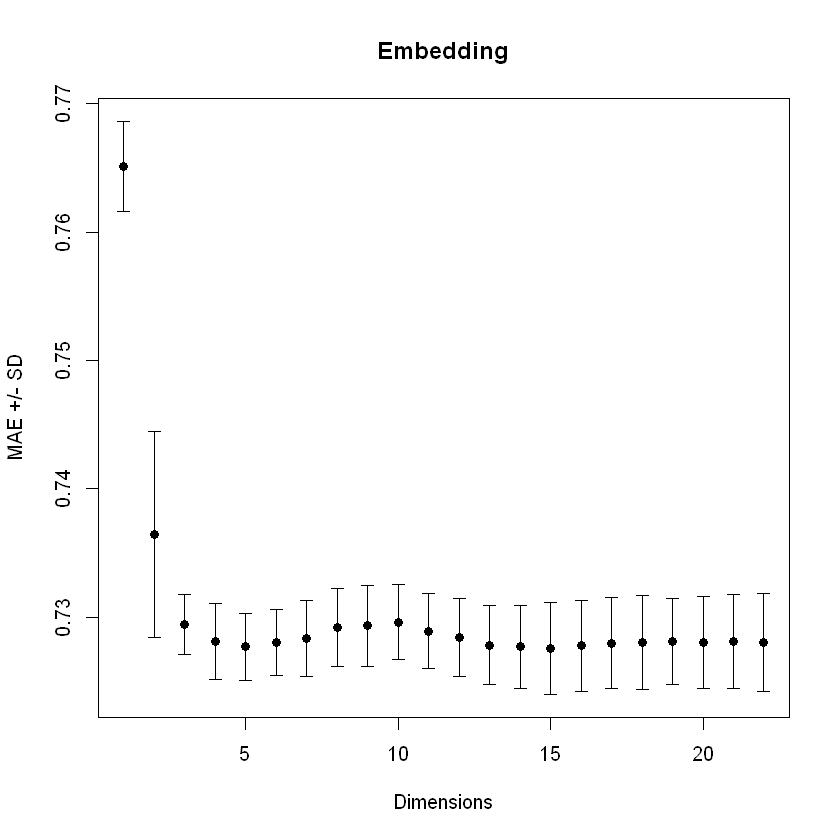

In [323]:
plot(x,colMeans(to.plot),ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Embedding"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [321]:
mean(cv.c)

[1] 0.7297082

In [322]:
write.table(avg, file="out/total/embed.csv")